In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')
from nebula.misc import get_path, set_random_seed
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, "..")

import torch
from sklearn.metrics import roc_curve
from nebula.attention import TransformerEncoderLM

from tqdm import tqdm

outPlotDir = os.path.join("..", "img", "_maskedLanguageModelPlots")
os.makedirs(outPlotDir, exist_ok=True)

FPRATES = ['0.0001', '0.0003', '0.001', '0.003', '0.01', '0.03', '0.1']

In [2]:
def plotLineScatterWithErr(valueTable, errorTable, title, xlabel, ylabel, ax=None, figsize=(10, 8)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    for key in valueTable:
        ax.errorbar(valueTable[key].index, valueTable[key], yerr=errorTable[key], marker="o", label=key, capsize=5)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid()
    ax.legend()
    return ax

def trainingDumpFolder(folder, pattern = "Losses.npy"):
    lossFiles = [file for file in os.listdir(folder) if file.endswith(pattern)]
    losses = np.vstack([np.load(os.path.join(folder, losses)) for losses in lossFiles])
    lossesMean = np.mean(losses, axis=0)
    lossesStd = np.std(losses, axis=0)
    return lossesMean, lossesStd

def plotLossesErrorShade(mean, std, ax=None, figsize=(10, 8)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.plot(mean, label="mean")
    ax.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=0.5, label="std")
    return ax

def plotErrorShadeStats(folders, pattern = "Losses.npy", ax = None, figsize=(10, 8), xlim = None):
    meanPretrained, stdPretrained = trainingDumpFolder(folders[0], pattern)
    meanNonPretrained, stdNonPretrained = trainingDumpFolder(folders[1], pattern)
    meanFull, stdFull = trainingDumpFolder(folders[2], pattern)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(13, 6))
    plotLossesErrorShade(meanPretrained, stdPretrained, ax=ax)
    plotLossesErrorShade(meanNonPretrained, stdNonPretrained, ax=ax)
    #plotLossesErrorShade(meanFull, stdFull, ax=ax)
    ax.set_xlabel("Batches")
    ax.set_ylabel("Loss")
    ax.grid()
    ax.legend([ax.get_lines()[0], ax.get_lines()[1]], ["Pretrained", "NonPretrained"])
    if xlim:
        ax.set_xlim(xlim)
    return ax

def plotLineScatter(mean, std, ax=None, figsize=(10, 8)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.plot(mean, label="mean")
    ax.scatter(FPRATES, mean, label="mean")
    return ax

def plotLineScatterStats(folders, pattern, ylabel, ax=None, figsize=(10, 8)):
    meanPretrained, stdPretrained = trainingDumpFolder(folders[0], pattern)
    meanNonPretrained, stdNonPretrained = trainingDumpFolder(folders[1], pattern)
    meanFull, stdFull = trainingDumpFolder(folders[2], pattern)
    # put all the data above in dataframe
    statsMean = pd.DataFrame({"Pretrained": meanPretrained, "NonPretrained": meanNonPretrained, "Full": meanFull})
    statsStd = pd.DataFrame({"Pretrained": stdPretrained, "NonPretrained": stdNonPretrained, "Full": stdFull})

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    plotLineScatter(meanPretrained, stdPretrained, ax=ax)
    plotLineScatter(meanNonPretrained, stdNonPretrained, ax=ax)
    plotLineScatter(meanFull, stdFull, ax=ax)
    ax.legend([ax.get_lines()[0], ax.get_lines()[1], ax.get_lines()[2]], ["Pretrained", "NonPretrained", "Fullly Labeled\n(benchmark)"])
    #ax.set_xticklabels()
    # set the xticks to the values of the dataframe
    ax.set_xticks(statsMean.index)
    ax.set_ylabel(ylabel)
    ax.grid()
    return ax, statsMean, statsStd


In [3]:
def getMainStats(runFolder, lossXlim=(-5,70), dropPlots=True):
    runFolder = os.path.join("MaskedLanguageModeling", runFolder)
    metricFile = os.path.join(runFolder, [x for x in os.listdir(runFolder) if ("metric" in x) or ("results_full.json" in x)][0])
    outPlotPrefix = os.path.basename(runFolder)

    downstreamLossFolderPretrained = os.path.join(rf"{runFolder}", "downstreamTask_pretrained")
    downstreamLossFolderNonPretrained = os.path.join(rf"{runFolder}","downstreamTask_non_pretrained")
    downstreamLossFolderFull = os.path.join(rf"{runFolder}", "downstreamTask_full_data")
    folders = [downstreamLossFolderPretrained, downstreamLossFolderNonPretrained, downstreamLossFolderFull]
    if "training_files" in os.listdir(downstreamLossFolderFull):
        folders = [os.path.join(x, "training_files") for x in folders]

    # make 3 plots
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    plotErrorShadeStats(folders, ax=ax[0], xlim=lossXlim)
    pattern = "trainF1s.npy"
    _, f1s_train, f1errs_train = plotLineScatterStats(folders, pattern, ax=ax[1], ylabel="F1 Score")
    pattern = "trainTPRs.npy"
    plotLineScatterStats(folders, pattern, ax=ax[2], ylabel="TPR")
    fig.suptitle("Training Set Evaluation")
    fig.tight_layout()
    fig.savefig(os.path.join(outPlotDir, f"{outPlotPrefix}_trainSetStats.png"), dpi=300)

    with open(metricFile, 'r') as f:
        metrics = json.load(f)

    f1s_test = pd.DataFrame()
    f1errs_test = pd.DataFrame()
    tprs = pd.DataFrame()
    tprerrs = pd.DataFrame()
    for key in metrics:
        for fpr in [x for x in metrics[key] if "fpr" in x]:
            f1s_test.loc[fpr.strip("fpr_"), key] = metrics[key][fpr]['f1_mean']
            f1errs_test.loc[fpr.strip("fpr_"), key] = metrics[key][fpr]['f1_std']
            tprs.loc[fpr.strip("fpr_"), key] = metrics[key][fpr]['tpr_mean']
            tprerrs.loc[fpr.strip("fpr_"), key] = metrics[key][fpr]['tpr_std']

    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    plotLineScatterWithErr(tprs, tprerrs, "TPR score for different FPRs", "FPR", "F1 score", ax=ax[0])
    plotLineScatterWithErr(f1s_test, f1errs_test, "F1 score for different FPRs", "FPR", "F1 score", ax=ax[1])
    _ = fig.suptitle("Test set metrics for different FPRs", fontsize=16)
    if dropPlots:
        fig.tight_layout()
        fig.savefig(os.path.join(outPlotDir, f"{outPlotPrefix}_testSetStats.png"), dpi=300)
    return f1s_train, f1errs_train, f1s_test, f1errs_test

In [12]:
def plot_roc_curves(runFolder, modelIdx=0):
    xTestFile = os.path.join(REPO_ROOT, "data", "data_filtered", "speakeasy_testset_BPE", f"speakeasy_VocabSize_50000_maxLen_512_x.npy")
    xTest = np.load(xTestFile)
    yTestFile = os.path.join(REPO_ROOT, "data", "data_filtered", "speakeasy_testset_BPE", "speakeasy_y.npy")
    yTest = np.load(yTestFile)

    # limit to 100 samples
    xTest = torch.tensor(xTest, dtype=torch.long)
    yTest = torch.tensor(yTest, dtype=torch.float32)

    testLoader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(xTest, yTest),
        batch_size=64,
        shuffle=True)

    modelConfig = {
        "vocabSize": 50002,  # size of vocabulary
        "maxLen": 512,  # maximum length of the input sequence
        "dModel": 64,  # embedding & transformer dimension
        "nHeads": 8,  # number of heads in nn.MultiheadAttention
        "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
        "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        "numClasses": 1, # binary classification
        "hiddenNeurons": [64],
        "dropout": 0.3
    }

    modelFolders = [x for x in os.listdir(os.path.join("MaskedLanguageModeling", runFolder)) if "downstream" in x]
    modelFolders = [os.path.join("MaskedLanguageModeling", runFolder, x) for x in modelFolders]

    roc_curve_metrics = {}
    for modelFolder in modelFolders:
        name = os.path.basename(modelFolder).replace("downstreamTask_", "")
        print("Model folder:", name)
        modelFiles = [x for x in os.listdir(modelFolder) if x.endswith("torch")]
        modelFiles = [os.path.join(modelFolder, x) for x in modelFiles]
        roc_curves = []
        for i, modelFile in enumerate(modelFiles):
            # TODO: roc curves for different models provide different size of predictions
            # therefore, it is not possible to take mean/std directly
            # need some way to align the predictions
            if i != modelIdx: # for now only use the first model
                continue
            print("Model file:", os.path.basename(modelFile))
            model = TransformerEncoderLM(**modelConfig)
            model.load_state_dict(torch.load(modelFile))
            model.cuda()
            model.eval()
            with torch.no_grad():
                preds = []
                ys = []
                for i, (x, y) in enumerate(tqdm(testLoader)):
                    x = x.cuda()
                    yPred = model(x)
                    yPred = torch.sigmoid(yPred).cpu()
                    preds.append(yPred)
                    ys.append(y)
                preds = torch.cat(preds, dim=0)
                preds = preds.numpy()
                ys = torch.cat(ys, dim=0)
                ys = ys.numpy()
                fpr, tpr, thresholds = roc_curve(ys, preds)
                auc = np.trapz(tpr, fpr)
                print("AUC:", auc, "\n")
                roc_curves.append((fpr, tpr))
        # get mean and std of roc curves
        fprs = [x[0] for x in roc_curves]
        tprs = [x[1] for x in roc_curves]
        # TODO: this is not correct, need to interpolate the curves
        fpr_mean = np.mean(fprs, axis=0)
        fpr_std = np.std(fprs, axis=0)
        tpr_mean = np.mean(tprs, axis=0)
        tpr_std = np.std(tprs, axis=0)
        roc_curve_metrics[name] = (fpr_mean, fpr_std, tpr_mean, tpr_std)

    # plot roc curves
    fig, ax = plt.subplots(figsize=(10, 10))
    for key, value in roc_curve_metrics.items():
        fpr_mean, fpr_std, tpr_mean, tpr_std = value
        _ = ax.plot(fpr_mean, tpr_mean, label=key)
        #_ = ax.fill_between(fpr_mean, tpr_mean - tpr_std, tpr_mean + tpr_std, alpha=0.2)

    ax.grid()
    ax.legend(loc="lower right")
    ax.set_ylim(0.4, 1.1)
    ax.set_xlim(-0.1, 0.7)
    return ax

## unlabaled data size comparison

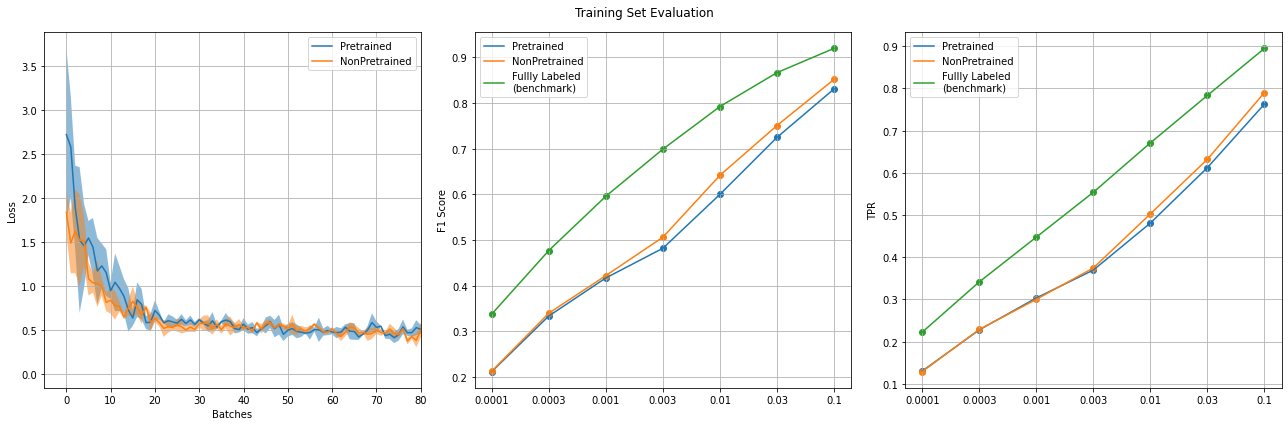

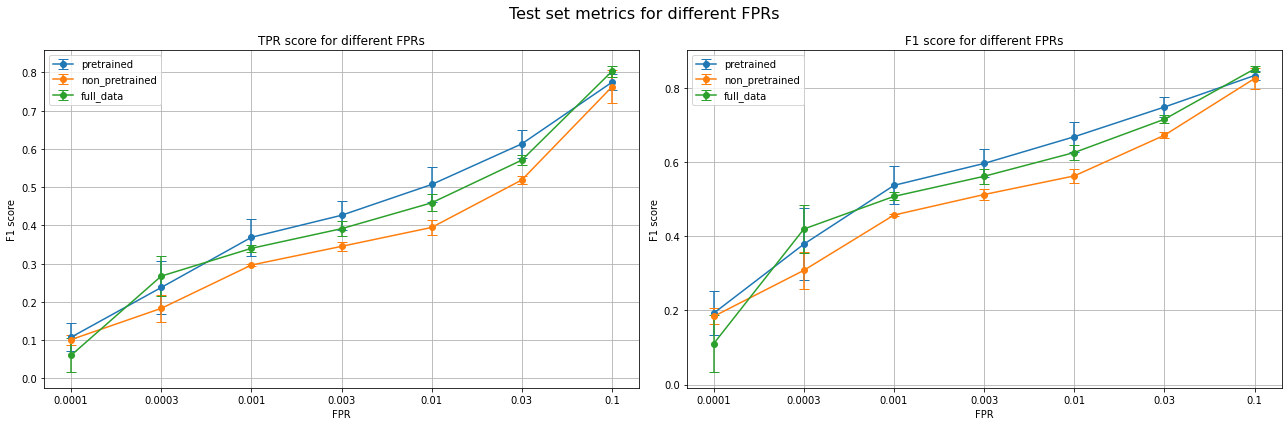

In [5]:
runFolder = r"uSize_0.7_1674899653"
f1s_train, f1errs_train, f1s_test, f1errs_test = getMainStats(runFolder, lossXlim=(-5,80))

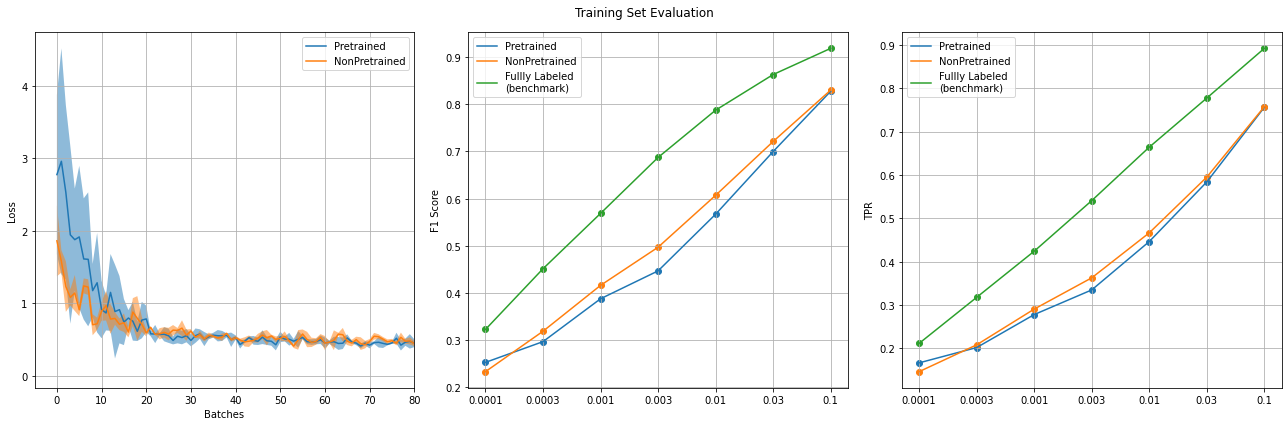

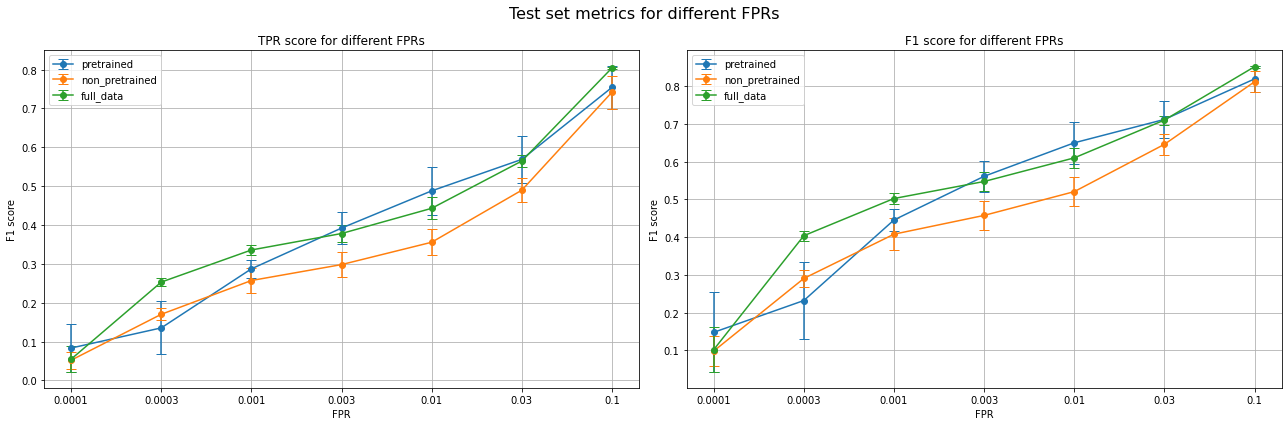

In [6]:
runFolder = r"uSize_0.75_1674904107"
f1s_train, f1errs_train, f1s_test, f1errs_test = getMainStats(runFolder, lossXlim=(-5,80))

## mask every time vs mask once

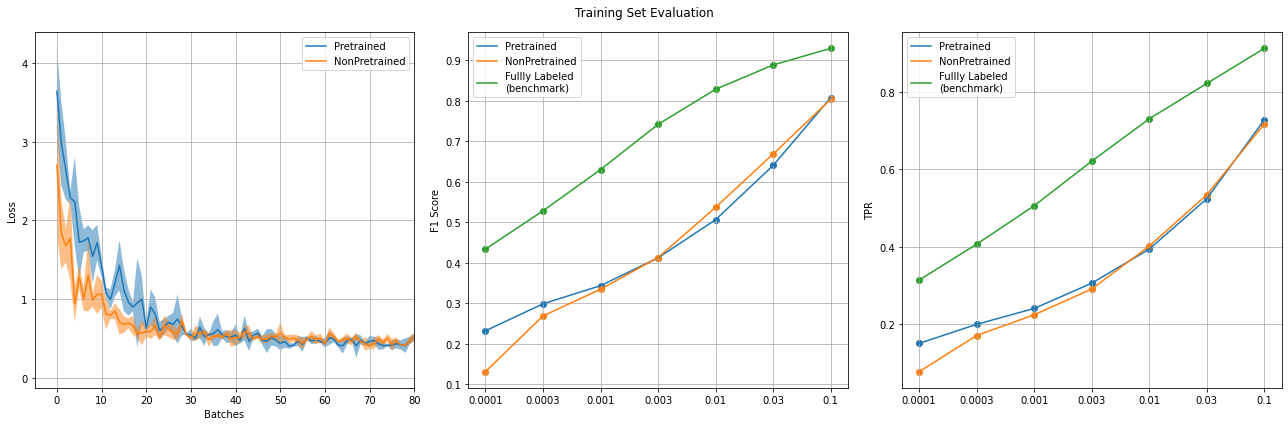

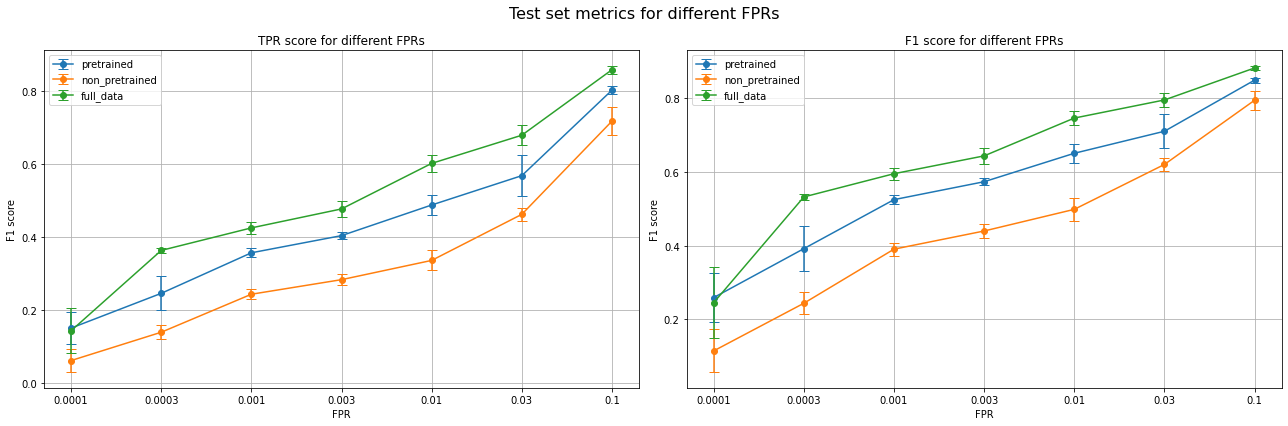

In [7]:
folder = "pretrain_epoch_analysis_1674855395"
f1s_train, f1errs_train, f1s_test, f1errs_test = getMainStats(folder, lossXlim=(-5,80))

Model folder: full_data
Model folder: non_pretrained
Model folder: pretrained


<AxesSubplot:>

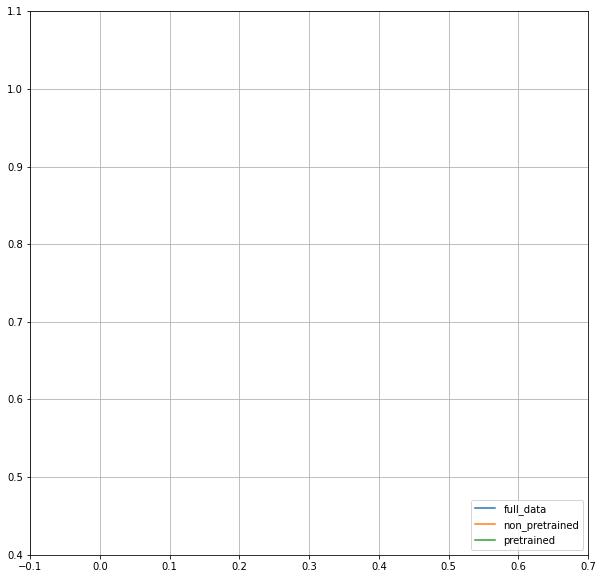

In [13]:
plot_roc_curves(runFolder, modelIdx=0)

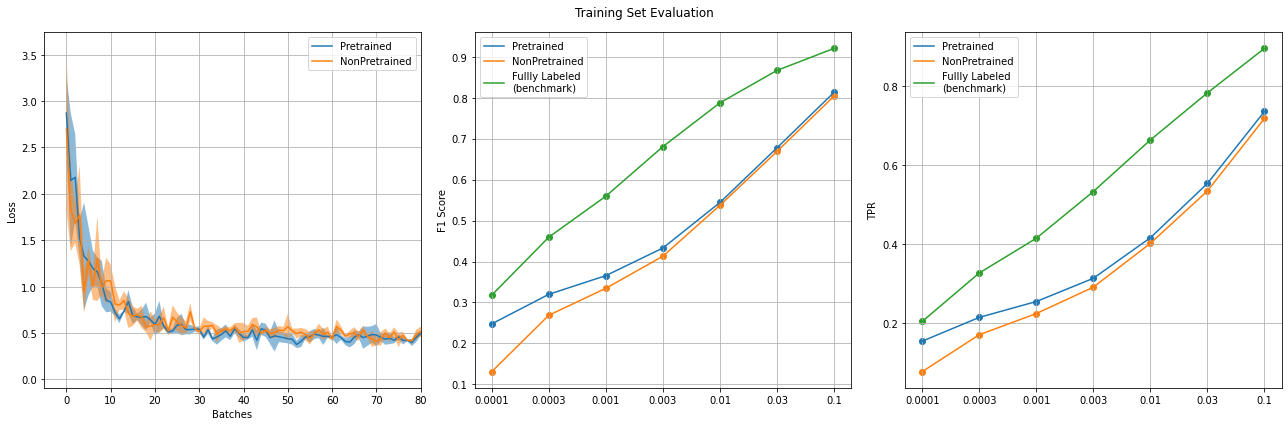

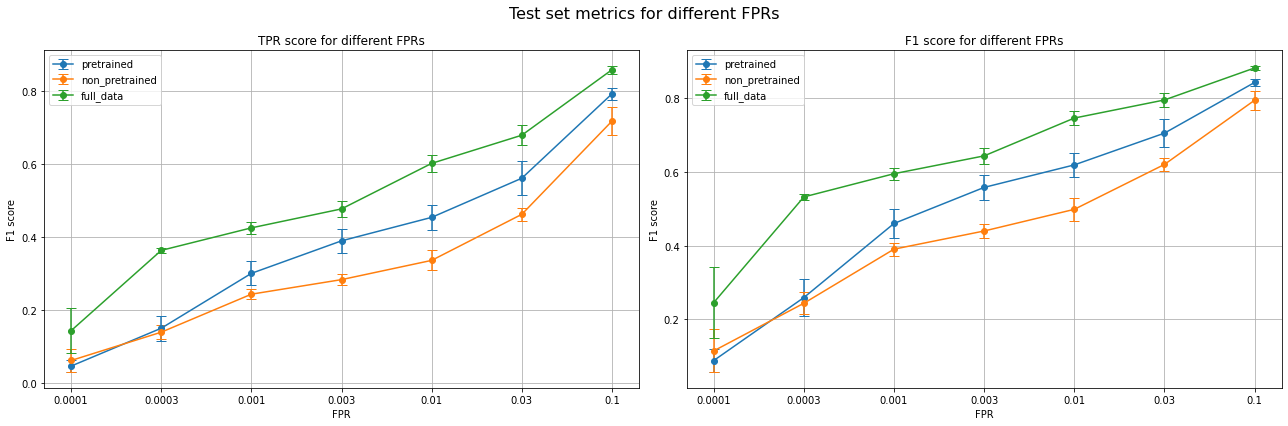

In [ ]:
folder = "pretrain_epoch_analysis_mask_every_epoch_1674909969"
f1s_train, f1errs_train, f1s_test, f1errs_test = getMainStats(folder, lossXlim=(-5,80))

In [ ]:
plot_roc_curves(runFolder, modelIdx=1)

Model folder: full_data
Model file: trainingFiles_1674593935-model.torch


100%|██████████| 272/272 [00:04<00:00, 57.59it/s]


AUC: 0.9490094764380015 

Model file: trainingFiles_1674594959-model.torch


100%|██████████| 272/272 [00:04<00:00, 57.64it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


AUC: 0.9459820897803783 



ValueError: operands could not be broadcast together with shapes (3399,) (3755,) 

## transformer analysis

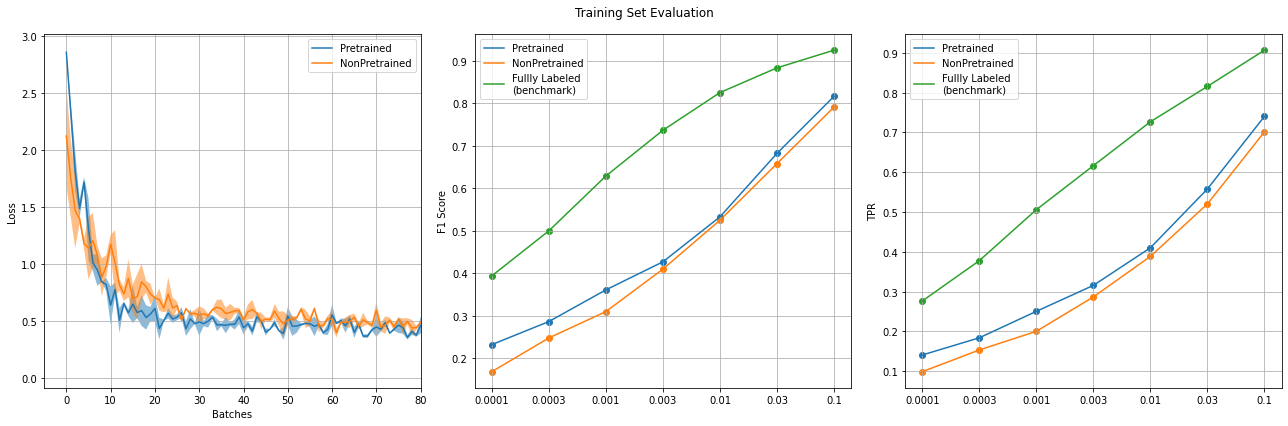

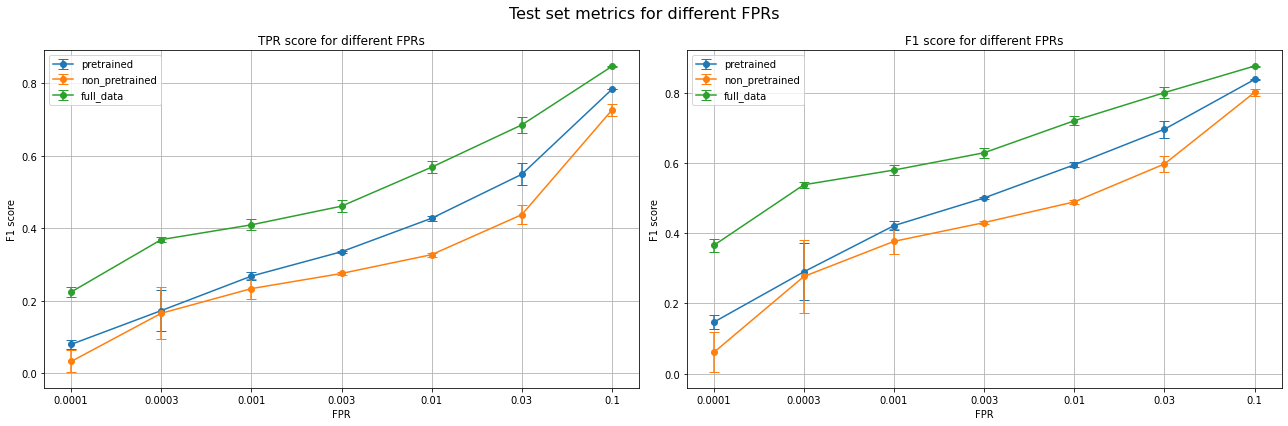

In [ ]:
runFolder = r"TransformerLM_unlabeledDataSize_0.8_preTrain_5_downStream_3_nSplits_2_1674592840"
f1s_train, f1errs_train, f1s_test, f1errs_test = getMainStats(runFolder, lossXlim=(-5,80))

Model folder: full_data
Model file: trainingFiles_1674594959-model.torch


100%|██████████| 272/272 [00:05<00:00, 50.27it/s]


AUC: 0.9454807983650417 

Model folder: non_pretrained
Model file: trainingFiles_1674594725-model.torch


100%|██████████| 272/272 [00:05<00:00, 50.67it/s]


AUC: 0.9168159858175773 

Model folder: pretrained
Model file: trainingFiles_1674594676-model.torch


100%|██████████| 272/272 [00:05<00:00, 51.99it/s]

AUC: 0.9332802690965483 



<AxesSubplot:>

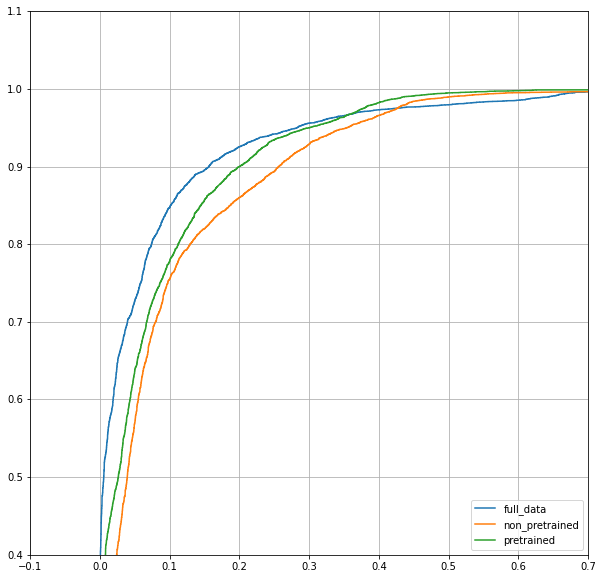

In [ ]:
plot_roc_curves(runFolder, modelIdx=1)

### Have interesting run where pre-trained model outperforms model trained on full data on Test set:

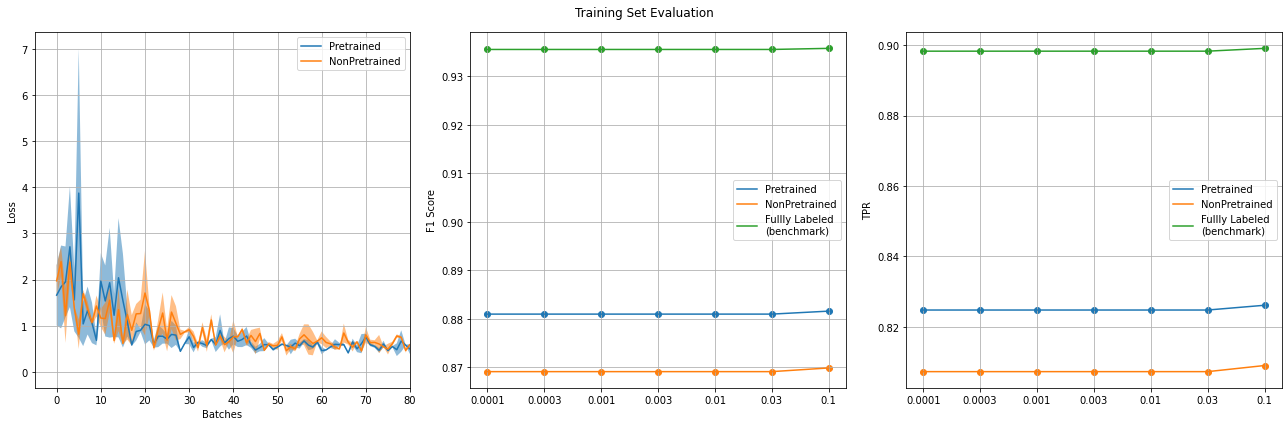

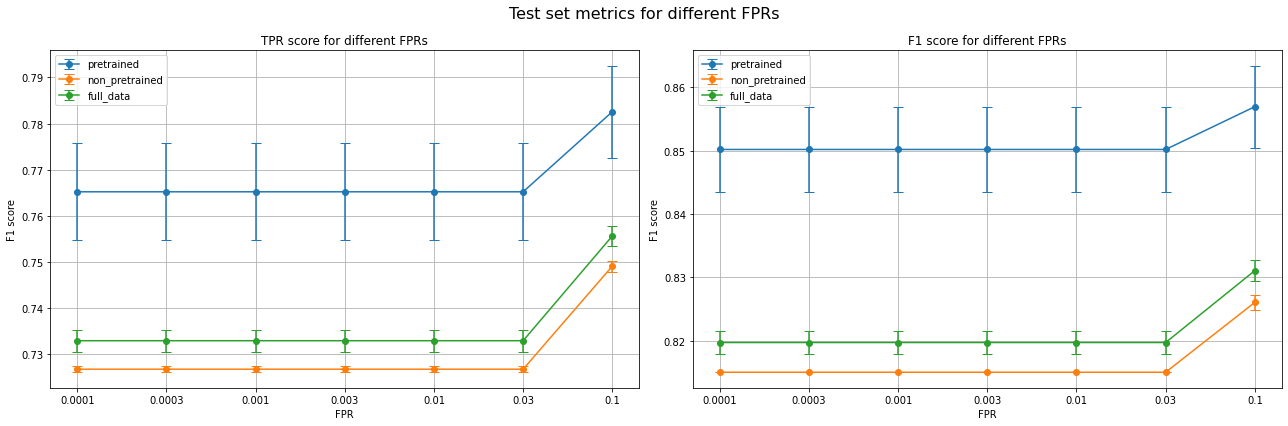

In [ ]:
runFolder = r"TransformerLM_Pre-Trained_Good_unlabeledDataSize_0.8_preTrain_5_downStream_3_nSplits_2_1674558203"
f1s_train, f1errs_train, f1s_test, f1errs_test = getMainStats(runFolder, lossXlim=(-5,80))

Model folder: full_data
Model file: trainingFiles_1674564734-model.torch


100%|██████████| 272/272 [00:05<00:00, 49.43it/s]


AUC: 0.9276509782968773 

Model folder: non_pretrained
Model file: trainingFiles_1674563977-model.torch


100%|██████████| 272/272 [00:05<00:00, 49.27it/s]


AUC: 0.9242483937229514 

Model folder: pretrained
Model file: trainingFiles_1674563825-model.torch


100%|██████████| 272/272 [00:05<00:00, 50.60it/s]


AUC: 0.9436327579589977 



<AxesSubplot:>

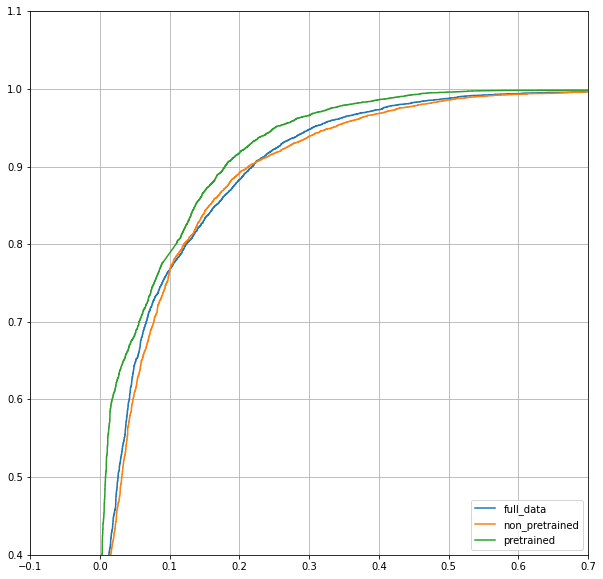

In [ ]:
plot_roc_curves(runFolder)

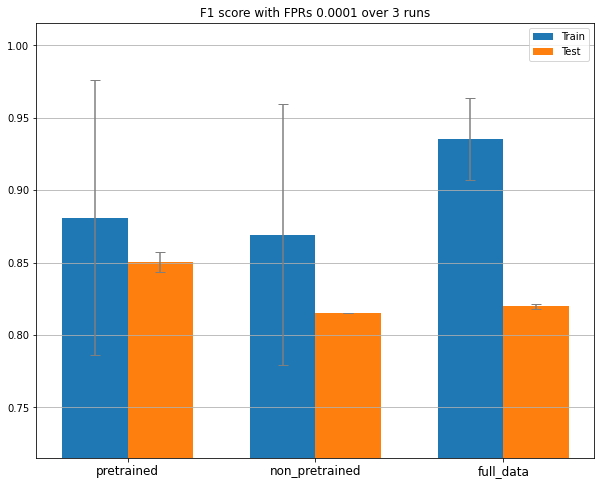

In [ ]:
f1s_train.index = f1s_test.index
f1s_train.columns = f1s_test.columns
f1errs_train.index = f1errs_test.index
f1errs_train.columns = f1errs_test.columns

key = '0.0001'
fig, ax = plt.subplots(figsize=(10, 8))
width = 0.35
x = np.arange(len(f1s_test.loc[key].index))
# plot bar as above but using plt.bar
ax.bar(x=x - width/2, height=f1s_train.loc[key], width=width, yerr=f1errs_train.loc[key], capsize=5, ecolor='tab:gray', label='Train')
ax.bar(x=x + width/2, height=f1s_test.loc[key], width=width, yerr=f1errs_test.loc[key], capsize=5, ecolor='tab:gray', label='Test')
# ylim to be -0.5 to +0.5 between min and max values of f1s_test
_ = ax.set_ylim(f1s_test.loc[key].min() - 0.1, f1s_train.loc[key].max() + 0.08)
ax.grid(axis='y')
ax.legend()
ax.set_xticks(x, f1s_test.loc[key].index)
_ = ax.tick_params(axis='x', labelsize=12)
_ = ax.set_title(f"F1 score with FPRs {key} over 3 runs")

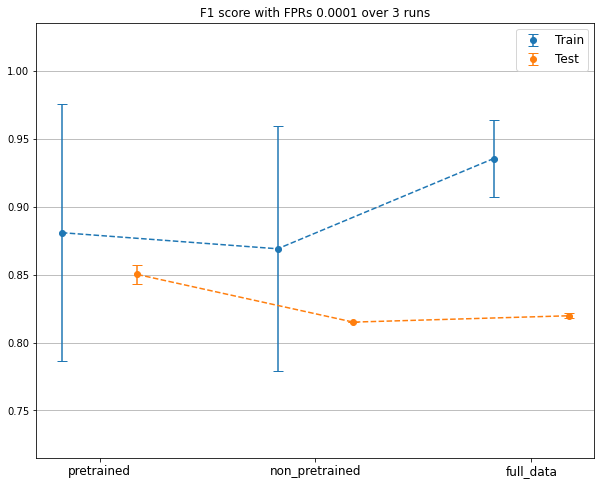

In [ ]:
# make barplot as above, but have two bars for f1s_test and f1s_train under the same xlabel
fig, ax = plt.subplots(figsize=(10, 8))
width = 0.35
x = np.arange(len(f1s_test.loc[key].index))
# ax.bar(x=x - width/2, height=f1s_train.loc[key], width=width, yerr=f1errs_train.loc[key], capsize=5, ecolor='darkgray', label='Train')
# ax.bar(x=x + width/2, height=f1s_test.loc[key], width=width, yerr=f1errs_test.loc[key], capsize=5, ecolor='darkgray', label='Test')
# make scatterplot with errorbars
_ = ax.errorbar(x=x - width/2, y=f1s_train.loc[key], yerr=f1errs_train.loc[key], capsize=5, ecolor='tab:blue', fmt='o', label='Train')
_ = ax.errorbar(x=x + width/2, y=f1s_test.loc[key], yerr=f1errs_test.loc[key], capsize=5, ecolor='tab:orange', fmt='o', label='Test')
# add lines
_ = ax.plot(x-width/2, f1s_train.loc[key], color='tab:blue', linestyle='--')
_ = ax.plot(x+width/2, f1s_test.loc[key], color='tab:orange', linestyle='--')

ax.set_xticks(x, f1s_test.loc[key].index)
_ = ax.set_ylim(f1s_test.loc[key].min() - 0.1, f1s_train.loc[key].max() + 0.1)
ax.grid(axis='y')
_ = ax.tick_params(axis='x', labelsize=12)
_ = ax.set_title(f"F1 score with FPRs {key} over 3 runs")
# add legend with incresed fontsize
_ = ax.legend(fontsize=12)